In [1]:
import datetime
import json
import os
import pickle
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import xobjects as xo
import xpart as xp
import xtrack as xt
from tqdm import tqdm

In [2]:
import normed_dynamic_indicators as ndi

In [3]:
context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextCpu()         # For CPU

MASK_PATH = "masks/"

selected_mask = "mask_b1_without_bb_21.json"

with open(f"masks/{selected_mask}", "r") as fid:
    loaded_dct = json.load(fid)

line = xt.Line.from_dict(loaded_dct)
tracker = xt.Tracker(_context=context, line=line)

# Attach a reference particle to the tracker
tracker.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=7e12)

twiss = tracker.twiss()

Done loading line from dict.           


In [4]:
disp = 1e-6

particles = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 10), # in sigmas
                               y_norm=np.linspace(0, 4, 10), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

particles_x = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 10)+disp, # in sigmas
                               y_norm=np.linspace(0, 4, 10), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

particles_y = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 10), # in sigmas
                               y_norm=np.linspace(0, 4, 10)+disp, # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

In [5]:
# if test.h5 exists, delete it
if os.path.exists("test.h5"):
    os.remove("test.h5")

ndi.track_log_displacement_singles_birkhoff(
    tracker,
    twiss,
    (2.5e-6, 2.5e-6),
    particles,
    [particles_x, particles_y],
    ["disp_x", "disp_y"],
    disp,
    [10, 100, 200],
    context,
    ndi.H5pyWriter("test.h5")
)

100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


In [6]:
f = h5py.File("test.h5", "r")

In [7]:
f.keys()

<KeysViewHDF5 ['disp_x', 'disp_y', 'reference']>

In [8]:
print(f["disp_x/log_disp_nobirk/200"][...])
print(f["disp_y/log_disp_nobirk/200"][...])

[-1.97098511e-07  1.11019803e-07  6.59674753e-06  3.45043302e-05
  1.07515571e-04  2.49750175e-04  4.70096241e-04  7.56542466e-04
  1.08244937e-03  1.42164069e-03]
[8.44022658e-08 3.37709757e-07 8.00912494e-07 7.14362658e-06
 3.27727240e-05 1.04083367e-04 2.62957070e-04 5.41503292e-04
 9.23068630e-04 1.33295170e-03]


In [9]:
f["disp_x/normed_direction/x_norm/10"][...]**2 + f["disp_x/normed_direction/y_norm/10"][...]**2 + f["disp_x/normed_direction/px_norm/10"][...]**2 + f["disp_x/normed_direction/py_norm/10"][...]**2 + f["disp_x/normed_direction/zeta_norm/10"][...]**2 + f["disp_x/normed_direction/pzeta_norm/10"][...]**2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
particles = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 5, 20), # in sigmas
                               y_norm=np.linspace(0, 5, 20), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

# if test_rem.h5 exists, delete it
if os.path.exists("test_rem.h5"):
    os.remove("test_rem.h5")

ndi.track_reverse_error_method(
    tracker,
    twiss,
    (2.5e-6, 2.5e-6),
    particles,
    [10, 100, 2000],
    context,
    ndi.H5pyWriter("test_rem.h5")
)

Tracking 10 turns... (1/3)
Tracking 100 turns... (2/3)
Tracking 2000 turns... (3/3)


In [26]:
f = h5py.File("test_rem.h5", "r")
f.keys()

<KeysViewHDF5 ['reference', 'reverse']>

In [27]:
print(f["reverse/x_norm/200"][...])
print(f["reference/initial/x_norm"][...])

KeyError: "Unable to open object (object '200' doesn't exist)"

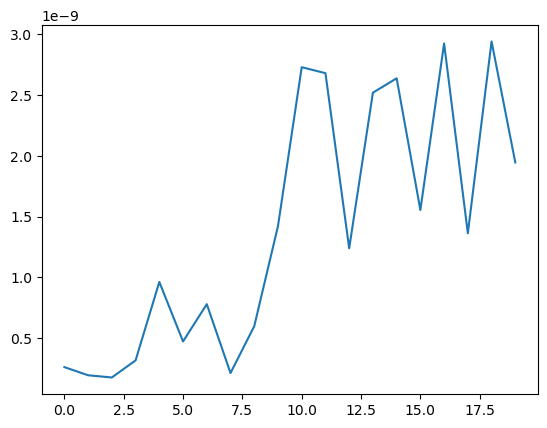

In [29]:
plt.plot(np.sqrt((f["reverse/x_norm/2000"][...] - f["reference/initial/x_norm"][...]) ** 2 + (f["reverse/y_norm/2000"][...] - f["reference/initial/y_norm"][...]) ** 2 + (f["reverse/px_norm/2000"][...] - f["reference/initial/px_norm"][...]) ** 2 + (f["reverse/py_norm/2000"][...] - f["reference/initial/py_norm"][...]) ** 2 + (f["reverse/zeta_norm/2000"][...] - f["reference/initial/zeta_norm"][...]) ** 2 + (f["reverse/pzeta_norm/2000"][...] - f["reference/initial/pzeta_norm"][...]) ** 2))

In [13]:
particles.at_element

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
twiss.get_normalized_coordinates(particles, nemitt_x=2.5e-6, nemitt_y=2.5e-6)

{'particle_id': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'at_element': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'x_norm': array([2.02809458e-11, 4.44343442e-01, 8.88743148e-01, 1.32952447e+00,
        1.75589339e+00, 2.14669980e+00, 2.46779106e+00, 2.67071234e+00,
        2.69383256e+00, 2.46713108e+00]),
 'px_norm': array([ 5.22836660e-11, -1.00466028e-02,  1.00296165e-02,  9.02005794e-02,
         2.59841643e-01,  5.46288261e-01,  9.71792966e-01,  1.54838851e+00,
         2.27041352e+00,  3.10500018e+00]),
 'y_norm': array([1.21135449e-12, 4.44487498e-01, 8.88119084e-01, 1.32473937e+00,
        1.73964603e+00, 2.10686705e+00, 2.38791983e+00, 2.53324496e+00,
        2.48735989e+00, 2.19752928e+00]),
 'py_norm': array([-2.48881970e-11, -4.58722632e-03,  2.12033523e-02,  1.05348080e-01,
         2.73601334e-01,  5.48954562e-01,  9.50034307e-01,  1.48803877e+00,
         2.16189744e+00,  2.95126460e+00]),
 'zeta_norm': array([-2.44521097e-12,  3.41573385e-09,  1.24800689e-08,  2.71162266e-

In [19]:
particles = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 10), # in sigmas
                               y_norm=np.linspace(0, 4, 10), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

# if test_stab.h5 exists, delete it
if os.path.exists("test_stab.h5"):
    os.remove("test_stab.h5")

ndi.track_stability(
    tracker,
    particles,
    2000,
    context,
    ndi.H5pyWriter("test_stab.h5")
)

Starting at: 2023-02-14 11:48:43.764917
Finished at: 2023-02-14 11:49:27.519145
Hours elapsed: 0.012153952222222222


In [20]:
f = h5py.File("test_stab.h5", "r")
f.keys()

<KeysViewHDF5 ['stability']>

In [21]:
f["stability"][...]

array([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])

In [ ]:
particles = tracker.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 10), # in sigmas
                               y_norm=np.linspace(0, 4, 10), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

# if test_tune.h5 exists, delete it
if os.path.exists("test_tune.h5"):
    os.remove("test_tune.h5")

ndi.track_tune_birkhoff(
    tracker,
    twiss,
    (2.5e-6, 2.5e-6),
    particles,
    [0, 0, 0, 10, 100, 1000],
    [10, 100, 1000, 20, 200, 2000],
    context,
    ndi.H5pyWriter("test_tune.h5")
)

Starting at: 2023-02-14 11:48:43.764917
Finished at: 2023-02-14 11:49:27.519145
Hours elapsed: 0.012153952222222222
